## Broadening Tutorial

In science, we often have to deal with distributions. Whether there is some a distribution of noise in our data, or some underlying physics influencing our measurements, we will always have to contend with these background processes. This is often discussed in terms of a convolutions, where two processes mix together at every point (usually one process you actually care about and another process that you couldn't care less about). 

Mathematically a convolution is defined as $$[f \star g](x) = \int_{-\infty}^{\infty} f(\tau)g(x-\tau) d\tau$$
They are a well studied mathematical phenomena with many creative animations and explanations that can be found elsewhere ([link1](https://mathworld.wolfram.com/Convolution.html), [link2](https://www.youtube.com/watch?v=KuXjwB4LzSA&ab_channel=3Blue1Brown)). In the context of measured data, we usually use the word "broadening" instead of convolution, but they effectively mean the same thing. Usually our data is convolved with some other distribution which ends up broadening peaks and making any features fuzzier. Given this, being able to simulate broadening is critical for comparing theory to experiment, and also is generally helpful for understanding what is going on within our data. In this Jupyter notebook I will discuss how to implement broadening within Python for a few situations, as well as some common pitfalls that you will want to watch out for.

## Introduction

To begin let's start by getting comfortable with the tools that we are going to be working with. Below are a few of the distributions that I encounter most commonly in my research, but the lessons we develop with these examples will be entirely generalizable.

- Gaussian: By far the most well known distribution in all of science thanks to the central limit theorem $$G(x, \sigma) = \frac{1}{\sigma \sqrt(2 \pi)} exp \left( -\frac{1}{2} \frac{(x-\mu)^2}{\sigma^2} \right)$$
- Lorentzian: Sometimes refered to as a Cauchy distribution $$L(x, \Gamma) = \frac{1}{\pi} \frac{\Gamma/2}{(x-\mu)^2 - (\Gamma/2)^2} $$
- Voigt: Convolution of a Gaussian and a Lorentzian (just to add a little spice) $$ V(x, \sigma, \Gamma) = \int_{-\infty}^{\infty} G(x', \sigma)L(x-x', \Gamma) dx' $$

In [2]:
import scipy.special
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

import time
import importlib

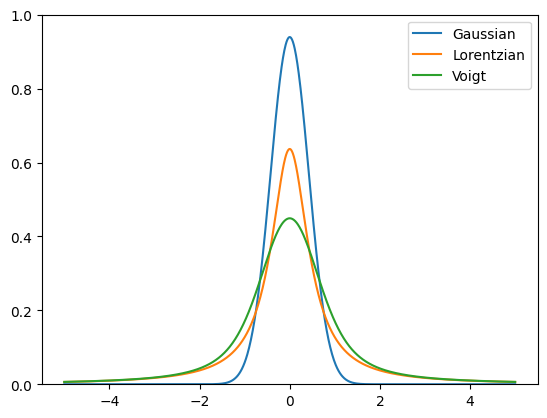

In [3]:
# FWHM = Full Width at Half Maximum, basically how wide (or fat) the peak is
# N = Multiplicative factor, N=1 means the normalized curve is multiplied everywhere by 1
# mu = x offset, basically where the tallest point of the peak is

G_FWHM = 1
L_FWHM = 1
N = 1
mu = 0

x = np.linspace(-5, 5, 1001)
plt.plot(x, ut.Gaussian(x, N, G_FWHM, mu), label = "Gaussian")
plt.plot(x, ut.Lorentzian(x, N, L_FWHM, mu), label = "Lorentzian")
plt.plot(x, ut.Voigt(x, N, G_FWHM, L_FWHM, mu), label = "Voigt")
plt.legend()
plt.ylim(0,1)
plt.show()

Scipy does the heavy lifting of already giving us a built in function, the Voigt function, which is the convolution of a Gaussian and a Lorentzian. In this case, if my signal was the Gaussian (blue), I would say it is "broadened" by a Lorentzian (orange), resulting in a Voigt (green). 

## Section 1: How to calculate a convolution in Python

Let's see if we can do make a Voigt by ourselves without cheating from Scipy's special library (that is what I used to calculate the Voigt in the previous plot).

The nature of the problem lends itself most directly to a double for loop. We need to integrate (sum) over an entire range of values (-$\infty$ to $\infty$) for each value of the new function (the convolution). Go back to the equation we defined at the beginning, or some of the references if you are confused by this statement.

Take some time to read through the logic in the functions below, and convince yourself that you understand what they doing. Start with the `LorentzianBroadening_slow` as it is a slightly simpler formula than the Gaussian one.

### Slow Method (Double For Loop)

Time to completion: 1.7962777614593506


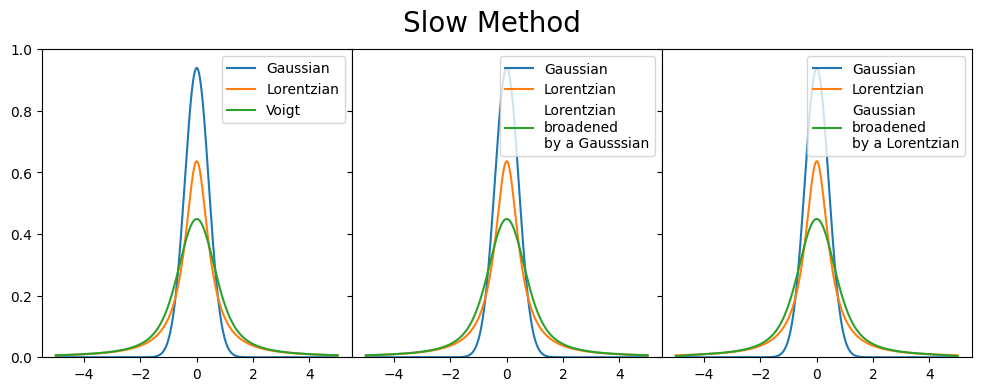

In [4]:
def LorentzianBroadening_slow(arr, FWHM):
    temp = np.zeros(len(arr[0]))
    dtau = np.abs(arr[0][1]-arr[0][0])
    for i_out in range(len(arr[0])):
        for i_in in range(len(arr[0])):
            # [f \star g](x) = \int_{-\infty}^{\infty} f(x) * g(x-tau) * dtau
            # f(x) => arr[1][i_in]
            # g(x-tau) => FWHM/(2*np.pi) / ((dtau*(i_out-i_in))**2 + (FWHM/2)**2)
            # dtau => dtau
            temp[i_out] += arr[1][i_in] * FWHM/(2*np.pi) / ((dtau*(i_out-i_in))**2 + (FWHM/2)**2) * dtau
    arr[1] = np.asarray(temp)
    return arr

def GaussianBroadening_slow(arr, FWHM):
    temp = np.zeros(len(arr[0]))
    dtau = np.abs(arr[0][1]-arr[0][0])
    sigma = FWHM/(2*np.sqrt(2*np.log(2)))
    norm_const = 1 / (sigma * np.sqrt(2*np.pi))
    for i_out in range(len(arr[0])):
        for i_in in range(len(arr[0])):
            temp[i_out] += arr[1][i_in] * norm_const * np.exp(-1/2 * ((i_out-i_in)*dtau)**2 / sigma**2) * dtau
    arr[1] = np.array(temp)
    return arr

start_time = time.time()

fig, ax = plt.subplots(1,3, sharey=True, figsize=(12, 4))
fig.subplots_adjust(wspace=0)

ax[0].plot(x, ut.Gaussian(x, N, G_FWHM, mu), label = "Gaussian")
ax[0].plot(x, ut.Lorentzian(x, N, L_FWHM, mu), label = "Lorentzian")
ax[0].plot(x, ut.Voigt(x, N, G_FWHM, L_FWHM, mu), label = "Voigt")

arr_LbyG = LorentzianBroadening_slow(arr = [x, ut.Gaussian(x, N, G_FWHM, mu)], FWHM = 1.0)
ax[1].plot(x, ut.Gaussian(x, N, G_FWHM, mu), label = "Gaussian")
ax[1].plot(x, ut.Lorentzian(x, N, L_FWHM, mu), label = "Lorentzian")
ax[1].plot(arr_LbyG[0], arr_LbyG[1], label="Lorentzian\nbroadened\nby a Gausssian")

arr_GbyL = GaussianBroadening_slow(arr = [x, ut.Lorentzian(x, N, L_FWHM, mu)], FWHM = 1.0)
ax[2].plot(x, ut.Gaussian(x, N, G_FWHM, mu), label = "Gaussian")
ax[2].plot(x, ut.Lorentzian(x, N, L_FWHM, mu), label = "Lorentzian")
ax[2].plot(arr_GbyL[0], arr_GbyL[1], label="Gaussian\nbroadened\nby a Lorentzian")

end_time = time.time()
print("Time to completion:", end_time - start_time)

for i in range(3):
    ax[i].legend()
    ax[i].set_ylim(0,1)

fig.suptitle("Slow Method", fontsize = 20)
plt.show()

You probably have noticed that the two functions defined above are followed by the suffix `_slow`. This is because a double for loop, while illustrative of the task, is not the most efficient way to calculate the broadened curve. In fact, we can take advantage of some of numpy's efficiency by doing one of the loops in terms of numpy arrays.

### Fast Method (Numpy Arrays)

Time to completion: 0.042588233947753906


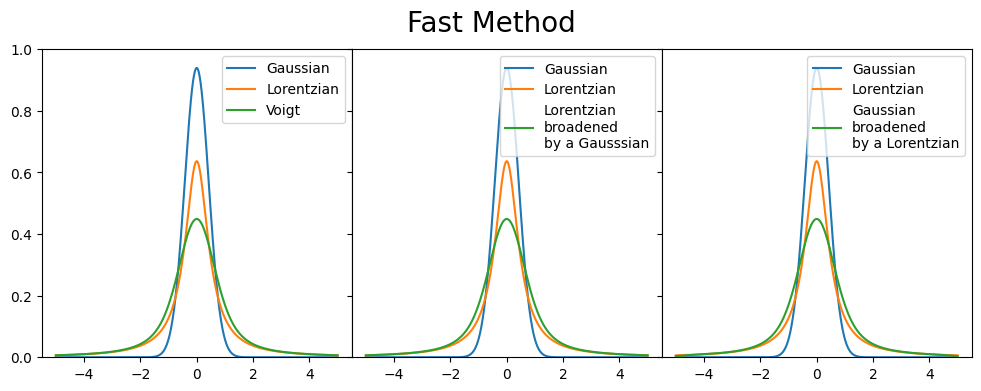

In [5]:
def LorentzianBroadening_fast(arr, FWHM):
    temp = np.zeros(len(arr[0]))  
    dtau = np.abs(arr[0][1]-arr[0][0])
    for i in range(len(arr[0])):
        kernel = FWHM/(2*np.pi) * 1/((arr[0]-arr[0][i])**2 + (FWHM/2)**2)
        temp[i] = np.dot(kernel,arr[1]) * dtau
    arr[1] = np.array(temp)
    return arr

def GaussianBroadening_fast(arr, FWHM):
    temp = np.zeros(len(arr[0]))
    dtau = np.abs(arr[0][1]-arr[0][0])
    sigma = FWHM/np.sqrt((8*np.log(2)))
    norm_const = 1 / (sigma * np.sqrt(2*np.pi))
    for i in range(len(arr[0])):
        kernel = norm_const * np.exp(-1/2 * (arr[0]-arr[0][i])**2 / sigma**2)
        temp[i] = np.dot(kernel,arr[1]) * dtau 
    arr[1] = np.array(temp)
    return arr

start_time = time.time()

fig, ax = plt.subplots(1,3, sharey=True, figsize=(12, 4))
fig.subplots_adjust(wspace=0)

ax[0].plot(x, ut.Gaussian(x, N, G_FWHM, mu), label = "Gaussian")
ax[0].plot(x, ut.Lorentzian(x, N, L_FWHM, mu), label = "Lorentzian")
ax[0].plot(x, ut.Voigt(x, N, G_FWHM, L_FWHM, mu), label = "Voigt")

arr_LbyG = LorentzianBroadening_fast(arr = [x, ut.Gaussian(x, N, G_FWHM, mu)], FWHM = 1.0)
ax[1].plot(x, ut.Gaussian(x, N, G_FWHM, mu), label = "Gaussian")
ax[1].plot(x, ut.Lorentzian(x, N, L_FWHM, mu), label = "Lorentzian")
ax[1].plot(arr_LbyG[0], arr_LbyG[1], label="Lorentzian\nbroadened\nby a Gausssian")

arr_GbyL = GaussianBroadening_fast(arr = [x, ut.Lorentzian(x, N, L_FWHM, mu)], FWHM = 1.0)
ax[2].plot(x, ut.Gaussian(x, N, G_FWHM, mu), label = "Gaussian")
ax[2].plot(x, ut.Lorentzian(x, N, L_FWHM, mu), label = "Lorentzian")
ax[2].plot(arr_GbyL[0], arr_GbyL[1], label="Gaussian\nbroadened\nby a Lorentzian")

end_time = time.time()
print("Time to completion:", end_time - start_time)

for i in range(3):
    ax[i].legend()
    ax[i].set_ylim(0,1)

fig.suptitle("Fast Method", fontsize = 20)
plt.show()

Let's pause here to acknowledge two things.

1. We managed to demonstrate that a Voigt function is indeed the convolution of a Lorentzian and a Gaussian. What's more is that it doesn't matter what order we perform the convolution in. Going Gaussian -> Lorentzian vs Lorentzian -> Gaussian gives the same curve. This is a general result, and it is also clear mathematically when we look at the formula for a convolution $$[f \star g](x) = \int_{-\infty}^{\infty} f(\tau)g(x-\tau) d\tau$$ and realize that if we swap our definitions of $f$ and $g$, and then perform u-substitution on the argument of g, we can return to the original equation ([proof](http://wittawat.com/posts/convolution_commutative.html)).

2. As with every coding task, there are many different ways to accomplish the same thing. However not all are necessarily equivalent. There is a nearly two order of magnitude difference between the double for loop and the numpy array methods, in terms of time saved. This becomes increasingly important when you start dealing with complicated spectra or functions that have a lot of data points.

The fastest implementation that I have ever seen involves the numpy.convolve function (shown below), and it is the one that I recommend using if you are ever working with very large data sets. However, it has the drawback of just being someone else's convolve function, without a lot of transparency. If you ever have an issue with your broadening and want to do some testing, you may have to go digging around in the numpy source code.

### Numpy Convolve Method


Time to completion: 0.030383586883544922


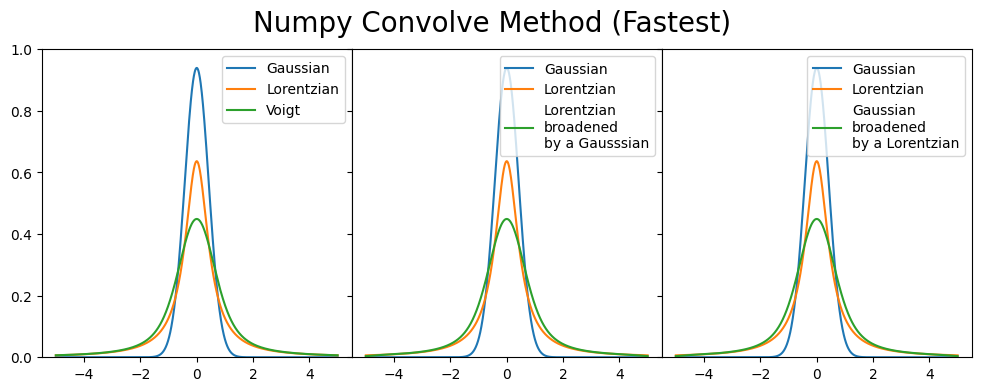

In [6]:
def LorentzianBroadening_convolve(arr, FWHM):
    dtau = np.abs(arr[0][1]-arr[0][0])
    Lorentzian = ut.Lorentzian(x=arr[0], N=1, FWHM=FWHM, mu=0)
    arr[1] = np.convolve(arr[1], Lorentzian, mode="same") * dtau
    return arr

def GaussianBroadening_convolve(arr, FWHM):
    dtau = np.abs(arr[0][1]-arr[0][0])
    Gaussian = ut.Gaussian(x=arr[0], N=1, FWHM=FWHM, mu=0)
    arr[1] = np.convolve(arr[1], Gaussian, mode="same") * dtau
    return arr

start_time = time.time()

fig, ax = plt.subplots(1,3, sharey=True, figsize=(12, 4))
fig.subplots_adjust(wspace=0)

ax[0].plot(x, ut.Gaussian(x, N, G_FWHM, mu), label = "Gaussian")
ax[0].plot(x, ut.Lorentzian(x, N, L_FWHM, mu), label = "Lorentzian")
ax[0].plot(x, ut.Voigt(x, N, G_FWHM, L_FWHM, mu), label = "Voigt")

arr_LbyG = LorentzianBroadening_convolve(arr = [x, ut.Gaussian(x, N, G_FWHM, mu)], FWHM = 1.0)
ax[1].plot(x, ut.Gaussian(x, N, G_FWHM, mu), label = "Gaussian")
ax[1].plot(x, ut.Lorentzian(x, N, L_FWHM, mu), label = "Lorentzian")
ax[1].plot(arr_LbyG[0], arr_LbyG[1], label="Lorentzian\nbroadened\nby a Gausssian")

arr_GbyL = GaussianBroadening_convolve(arr = [x, ut.Lorentzian(x, N, L_FWHM, mu)], FWHM = 1.0)
ax[2].plot(x, ut.Gaussian(x, N, G_FWHM, mu), label = "Gaussian")
ax[2].plot(x, ut.Lorentzian(x, N, L_FWHM, mu), label = "Lorentzian")
ax[2].plot(arr_GbyL[0], arr_GbyL[1], label="Gaussian\nbroadened\nby a Lorentzian")


end_time = time.time()
print("Time to completion:", end_time - start_time)

for i in range(3):
    ax[i].legend()
    ax[i].set_ylim(0,1)

fig.suptitle("Numpy Convolve Method (Fastest)", fontsize = 20)
plt.show()

## Section 2: Common pitfalls

Okay, so now we know how to calculate the convolution of two functions within Python. How can we check our work? 

### Normalization
In general a convolution $(f \star g)(x)$ will have an area equal to the product of areas of the two functions being convolved ($f(x)$ and $g(x))$ ([proof](https://math.stackexchange.com/questions/3920639/is-convolution-area-preserving)). This is simple enough to check, so let's do so.

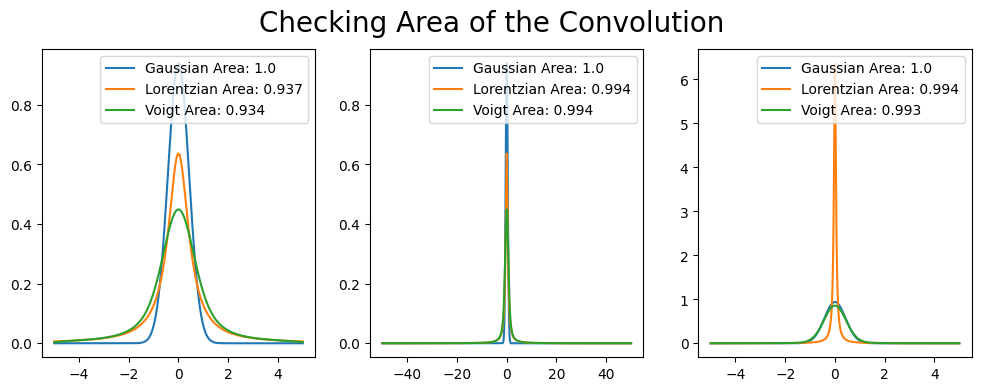

In [7]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))

# x-range of 10
x = np.linspace(-5, 5, 1001)
Lorentzian = ut.Lorentzian(x=x, N=1, FWHM=L_FWHM, mu=0)

Gaussian = ut.Gaussian(x=x, N=1, FWHM=G_FWHM, mu=0)
dtau = np.abs(x[1]-x[0])
Voigt = np.convolve(Gaussian, Lorentzian, mode="same") * dtau
G_area = "Gaussian Area: " + str(round(scipy.integrate.trapz(Gaussian, x),3))
L_area = "Lorentzian Area: " + str(round(scipy.integrate.trapz(Lorentzian, x),3))
V_area = "Voigt Area: " + str(round(scipy.integrate.trapz(Voigt, x),3))
ax[0].plot(x, Gaussian, label = G_area)
ax[0].plot(x, Lorentzian, label = L_area)
ax[0].plot(x, Voigt, label = V_area)
ax[0].legend()


# x-range of 100
x = np.linspace(-50, 50, 1001)
Lorentzian = ut.Lorentzian(x=x, N=1, FWHM=L_FWHM, mu=0)

Gaussian = ut.Gaussian(x=x, N=1, FWHM=G_FWHM, mu=0)
dtau = np.abs(x[1]-x[0])
Voigt = np.convolve(Gaussian, Lorentzian, mode="same") * dtau
G_area = "Gaussian Area: " + str(round(scipy.integrate.trapz(Gaussian, x),3))
L_area = "Lorentzian Area: " + str(round(scipy.integrate.trapz(Lorentzian, x),3))
V_area = "Voigt Area: " + str(round(scipy.integrate.trapz(Voigt, x),3))
ax[1].plot(x, Gaussian, label = G_area)
ax[1].plot(x, Lorentzian, label = L_area)
ax[1].plot(x, Voigt, label = V_area)
ax[1].legend()


# x-range of 10 but smaller L_FWHM
x = np.linspace(-5, 5, 1001)
Lorentzian = ut.Lorentzian(x=x, N=1, FWHM=L_FWHM/10, mu=0)

Gaussian = ut.Gaussian(x=x, N=1, FWHM=G_FWHM, mu=0)
dtau = np.abs(x[1]-x[0])
Voigt = np.convolve(Gaussian, Lorentzian, mode="same") * dtau
G_area = "Gaussian Area: " + str(round(scipy.integrate.trapz(Gaussian, x),3))
L_area = "Lorentzian Area: " + str(round(scipy.integrate.trapz(Lorentzian, x),3))
V_area = "Voigt Area: " + str(round(scipy.integrate.trapz(Voigt, x),3))
ax[2].plot(x, Gaussian, label = G_area)
ax[2].plot(x, Lorentzian, label = L_area)
ax[2].plot(x, Voigt, label = V_area)
ax[2].legend()

fig.suptitle("Checking Area of the Convolution", fontsize = 20)
plt.show()

Ah! This exercise was enlightening in multiple ways. Not only did it allow us to confirm that the product of the areas is indeed preserved through convolutions, but it showed us a shortcoming that was not necessarially tied the broadening method being used. A Lorentzian has especially long tails (compared to a Gaussian), and therefore still has non-negligible weight 5 units away from its peak. This can be quickly confirmed by plotting the above left subplot on a log axis (an exercise left to the reader).

The formula we use for a Lorentzian (defined in utils) is normalized to 1 assuming that integration is performed from $-\infty$ to $\infty$, and therefore will integrate to less than 1 over the range $-10$ to $10$, which is exactly what we see. What's more, the area of the Voigt (0.93) is roughly equal to the area of the Lorentzian (0.93) times the area of the Gaussian (1.0), validating our earlier assertion. There is a slight disagreement on the order of $10^{-3}$ which is due to a combination of boundary effects from the numpy convolve function and the numerical integration.

When we expand the x range to $-50$ to $50$ we see that the Lorentzian tails have much more space to die off before reaching the edge, leading to an area much closer to 1. We also see that reducing the Lorentzian FWHM (making it more narrow) has the same effect. **The takeaway from this is that one needs to be careful about the edge behavior of whatever functions are being broadened together.** If you have a very large x range relative to the spread of the broadening function, then you are most likely fine. However edge effects start to become prevalent when the x-range is comparable to the FWHM (or whatever width paramter you use).

### Variable x-axis or Variable stepsize

There is one final pitfall that should be addressed: occasionally in science you can get data with a variable x-axis. As a theorist, this often happens to me when I digitize plots from a paper (only slightly faster than just emailing the authors) using some tool like [Web Plot Digitizer](https://automeris.io/WebPlotDigitizer/). If you look through all the broadening functions we have defined so far you will note that they all depend on the x-axis being uniform (equally spaced). This is a problem for a variable x-axis, because the stepsize will not always be the same, basically meaning that the $d\tau$ (stepsize) in our convolution equation is not a constant.

There are a few ways to deal with this, the first being simply rebinning your data to make it uniformly spaced. However this comes at the cost of potentially loosing information. You could also try linear interpolation between points, making the new stepsize equal to the smallest previous stepsize, but this isn't always reasonable. Finally, you could just use the broadening function that I am about to give you. This issue has come up enough in my research group that an older grad student actually passed this piece of code down to me, who had it passed down to her by an even older graduate student, who found it on stack overflow (of course). I have modified it for my own use, but with a bit of experimentation you should be able to also adapt it to your particular problem.

Matplotlib is dumb. If you get an error, try changing ncols to ncol


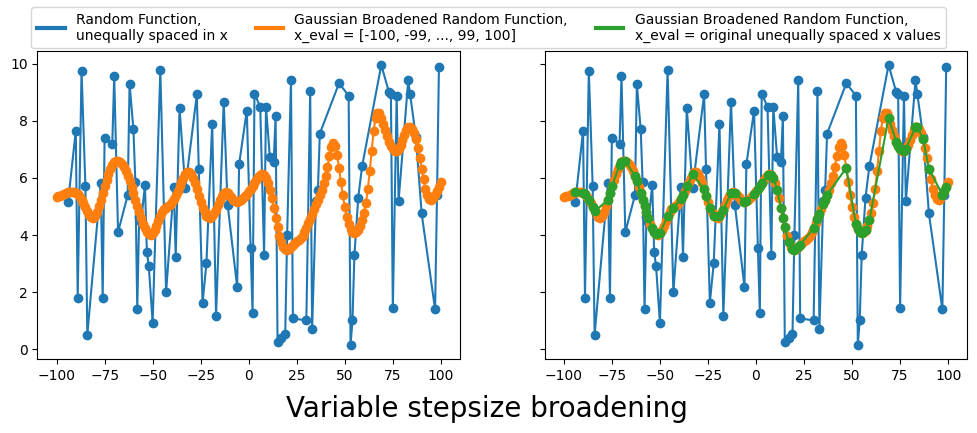

In [9]:
# From Sam's code, https://github.com/Seidler-Lab/Sulfur-ML (tddftoutputparser.py)
# Thank you stackoverflow
# https://stackoverflow.com/questions/24143320/gaussian-sum-filter-for-irregular-spaced-points
def gaussian_broaden(arr, FWHM, x_eval):
    '''
    Broadens an [x,y] 1D function by convolving it with a Gaussian. This aproach
    also works for broadening functions that that are unequally spaced in x, which is important for
    experimental spectra (in my experience).

    Parameters
    ----------
    arr: [x,y] numpy array
        The 1D function to be broadened where arr[0] is an array of x values,
        and arr[1] is an array of corresponding y values
    FWHM: float
        The FWHM of the Gaussian being used for broadening
    x_eval: numpy array
        x-values for the convolution to be evaluated at,
        this also does not need to be evenly spaced
    '''
    
    x, y = arr
    sigma = FWHM/(2*np.sqrt(2*np.log(2)))

    delta_x = x - x_eval[:, None]
    weights = np.exp(-delta_x*delta_x / (2*sigma*sigma)) / (np.sqrt(2*np.pi) * sigma)
    weights /= np.sum(weights, axis=1, keepdims=True)
    y_eval = np.dot(weights, y)

    return np.array([x_eval, y_eval])


fig, ax = plt.subplots(1,2, figsize=(12, 4), sharey=True)
x = np.unique(np.random.randint(low=-100, high=100, size=(1,100)))
y = np.random.random(size=(len(x))) * 10
ax[0].plot(x, y, 'o-')
ax[1].plot(x, y, 'o-')

x_eval = np.arange(-100, 100.1, 1)
arr = gaussian_broaden(arr=[x,y], FWHM=10, x_eval=x_eval)
ax[0].plot(arr[0], arr[1], 'o-')
ax[1].plot(arr[0], arr[1], 'o-')

x_eval = x
arr = gaussian_broaden(arr=[x,y], FWHM=10, x_eval=x_eval)
ax[1].plot(arr[0], arr[1], 'o-')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='tab:blue', lw=3, 
                    label='Random Function,\nunequally spaced in x'),
                   Line2D([0], [0], color='tab:orange', lw=3, 
                    label='Gaussian Broadened Random Function,\nx_eval = [-100, -99, ..., 99, 100]'),
                   Line2D([0], [0], color='tab:green', lw=3, 
                    label='Gaussian Broadened Random Function,\nx_eval = original unequally spaced x values'),]
print("Matplotlib is dumb. If you get an error, try changing ncols to ncol")
fig.legend(handles = legend_elements, ncols=3, loc=9)

fig.supxlabel("Variable stepsize broadening", fontsize = 20, y=-0.05)
plt.show()


Well that's the end of the tutorial. I wrote this somewhat quickly, as I've just spent the last 3 days resolving a particularly nasty bug in my own broadening function, and I wanted a place to summarize all that I've learned. Hopefully these lessons are helpful to someone out there. Thanks for reading this far, and the best of luck on your broadening adventures!